# High-Frequency Data

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
header = ['trade_id','price','quantity','order_id','timestamp','is_buyer_maker']
df = pd.read_csv('./BTCUSDT-trades-2023-05-31.csv',header=0 , names = header)
df.head()

,trade_id,price,quantity,order_id,timestamp,is_buyer_maker
0,3765419375,27680.0,0.400,11072.0000,1685491200110,True
1,3765419376,27680.0,0.006,166.0800,1685491200156,True
2,3765419377,27680.0,0.300,8304.0000,1685491200157,True
3,3765419378,27680.1,0.003,83.0403,1685491200244,False
4,3765419379,27680.1,0.003,83.0403,1685491203809,False


# Introduction

In many High-Frequency Trading papers, it is common to make the following assumptions:

- The time duration $\Delta t$ is sufficiently small.
- The terminal time $T$ is also small.  

Therefore, it is necessary to investigate the characteristics of high-frequency trading data.

In [6]:
def closed_time_series(df, time_interval):
    """
    Change tick data to OHLCV data
    """
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df = df.set_index('timestamp')
    df['quantity'] = df['quantity'] * df['price']
    df['buy_quantity'] = np.where(df['is_buyer_maker'], df['quantity'], 0)
    df['sell_quantity'] = np.where(df['is_buyer_maker'], 0, df['quantity'])
    df = df.resample(str(time_interval)+'S').agg({'price':'last', 'quantity':'sum', 'buy_quantity':'sum', 'sell_quantity':'sum'})
    df['return'] = df['price'].diff()
    df['log_return'] = np.log(df['price']) - np.log(df['price'].shift(1))
    df = df.dropna()
    df['volatility'] = df['return'].rolling(600).std()
    return df

According to Tsay's "Financial Time Series," there are interesting characteristics of intraday price changes, including a concentration on "no change" and discreteness. Let's investigate these characteristics step by step.

## Concentration on "no change"
To examine the concentration of price changes around zero, we can calculate the frequency distribution of price changes at small time intervals (e.g., seconds or minutes).   
By analyzing the distribution, we can determine if there is a significant number of instances where the price remains unchanged or experiences minimal fluctuations.

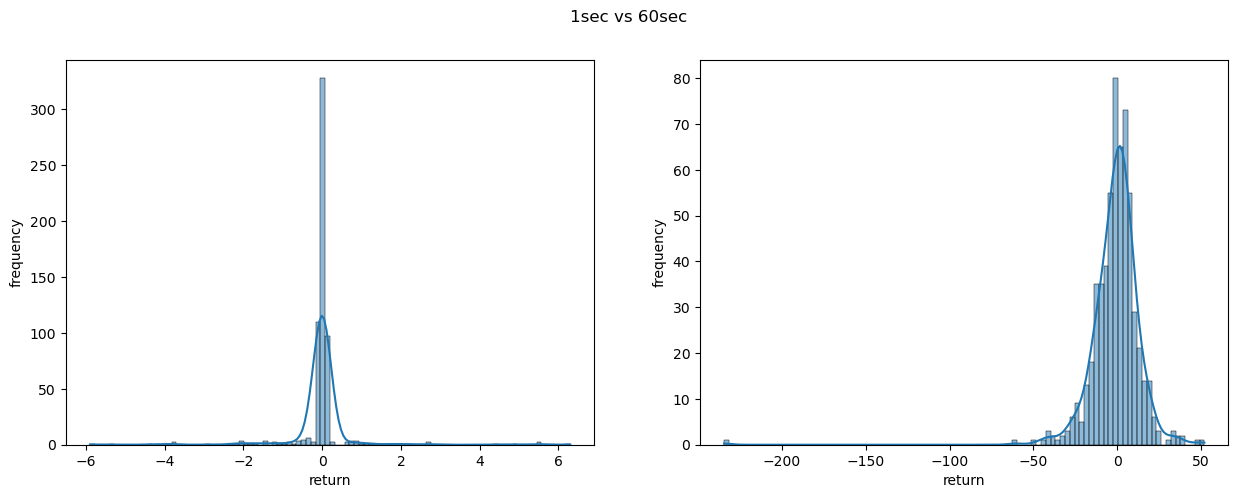

In [7]:
one_sec = closed_time_series(df, 1)[:600]
one_min = closed_time_series(df, 60)[:600]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('1sec vs 60sec')
sns.histplot(data=one_sec, x='return', bins=100, ax=axs[0], kde=True)
sns.histplot(data=one_min, x='return', bins=100, ax=axs[1], kde=True)
axs[0].set_ylabel('frequency')
axs[1].set_ylabel('frequency')
plt.show()

## Discreteness
The discreteness refers to the occurrence of discrete jumps or sudden changes in prices rather than continuous movements. This can be observed by plotting the intraday price series and examining whether there are frequent instances where prices exhibit sharp discontinuities or large jumps within short time intervals.

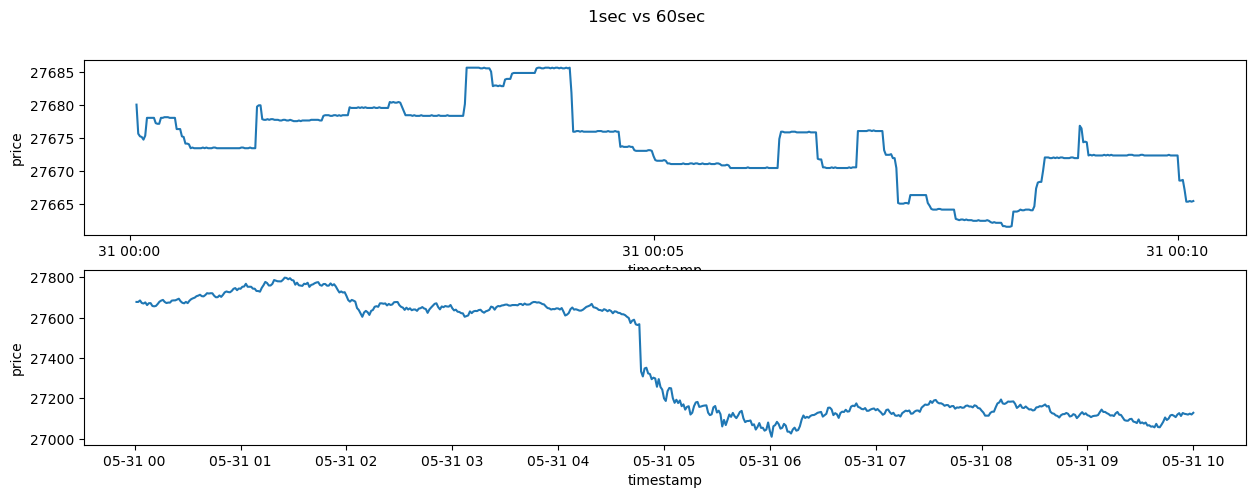

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(15, 5))
# one_min_slice = one_min[:600]
# one_sec_slice = one_sec[:600]
fig.suptitle('1sec vs 60sec')
sns.lineplot(data=one_sec, x=one_sec.index, y='price', ax=axs[0])
sns.lineplot(data=one_min, x=one_min.index, y='price', ax=axs[1])
plt.show()

## Exception Case : BTC/TUSD with zero trading fee
Recently, Binance initiated a zero trading fee promotion for the BTC/TUSD spot pair. This is an excellent opportunity for both regular traders and market makers as they can trade without incurring any fees. However, this has led to some interesting phenomena. In very short time durations, there are numerous price movements which are continuous.

This might be due to the increase in 'noise traders' who operate on incomplete information and typically have shorter trading durations. The absence of trading fees may encourage more noise traders to participate, leading to more frequent and continuous price movements.

However, a comprehensive understanding of these phenomena would require expertise in market microstructure theory.

In [10]:
header = ['number','price','quantity','start trade','end trade','timestamp','s','is_buyer_maker']
df = pd.read_csv('./BTCTUSD-aggTrades-2023-06-27.csv',header=0 , names = header)
df.head()

,number,price,quantity,start trade,end trade,timestamp,s,is_buyer_maker
0,173017437,30295.75,0.00181,215415073,215415073,1687824000301,True,True
1,173017438,30295.75,0.00472,215415074,215415074,1687824000308,True,True
2,173017439,30295.72,0.00128,215415075,215415075,1687824000308,True,True
3,173017440,30295.64,0.00132,215415076,215415076,1687824000308,True,True
4,173017441,30295.60,0.00400,215415077,215415078,1687824000308,True,True


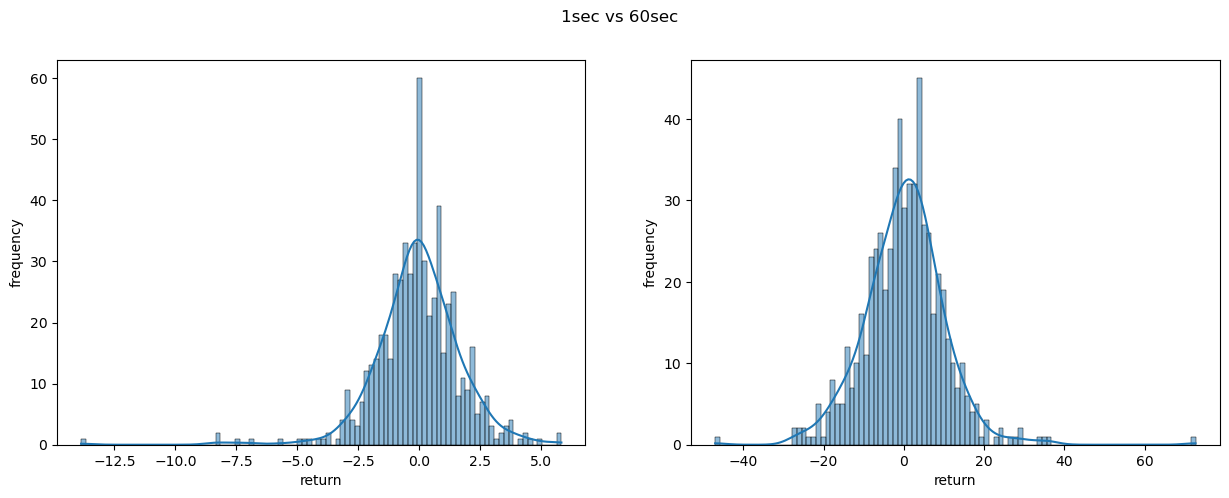

In [11]:
one_sec = closed_time_series(df, 1)[:600]
one_min = closed_time_series(df, 60)[:600]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('1sec vs 60sec')
sns.histplot(data=one_sec, x='return', bins=100, ax=axs[0], kde=True)
sns.histplot(data=one_min, x='return', bins=100, ax=axs[1], kde=True)
axs[0].set_ylabel('frequency')
axs[1].set_ylabel('frequency')
plt.show()

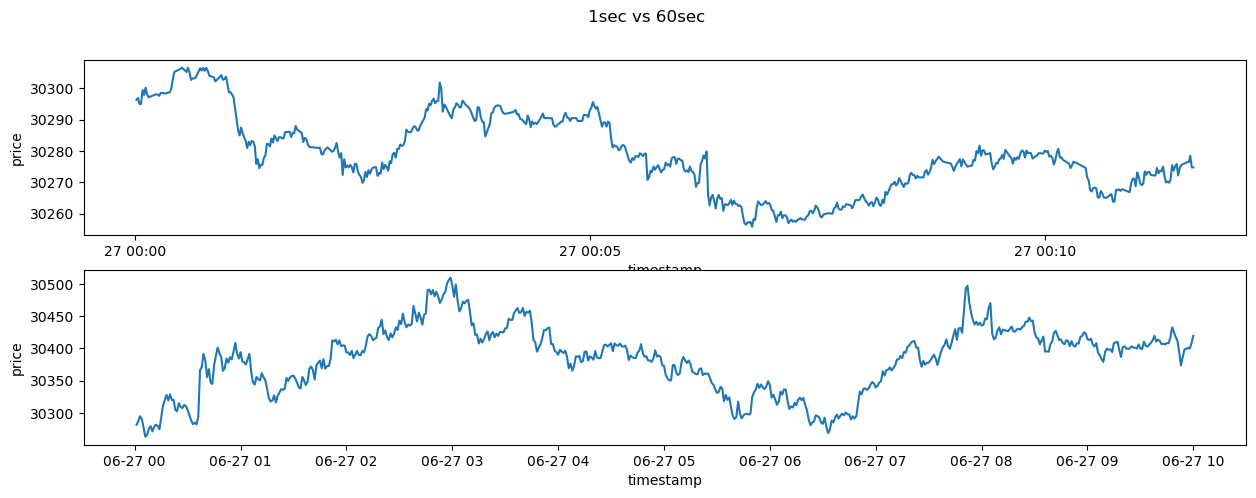

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(15, 5))
# one_min_slice = one_min[:600]
# one_sec_slice = one_sec[:600]
fig.suptitle('1sec vs 60sec')
sns.lineplot(data=one_sec, x=one_sec.index, y='price', ax=axs[0])
sns.lineplot(data=one_min, x=one_min.index, y='price', ax=axs[1])
plt.show()